# Warm-up: Numerical integration in Python
The SciPy routine `quad()` can be used to perform one-dimensional numerical integration in Python. Suppose we wish to use this routine to evaluate the integral
$$
\int_a^b(mx+k)dx
$$
We can do this by defining a function `g(x,m,k)` and passing this function to `quad()` in the following manner:

In [2]:
from scipy.integrate import quad

def g(x,m,k):
    return m*x+k

def g_integral(a,b,m,k):
    return (quad(g,a,b,args=(m,k)))[0]

print(g_integral(0.0,3.0,0.5,-1.0))

-0.75


With the chosen values for $a$, $b$, $m$ and $k$, this returns $-0.75$, which is what we also obtain if we solve the integral using these values analytically. Note here the calling convention for `quad()`: First the function to be integrated `g`, then the lower and upper integration bounds $a$ and $b$, followed by the keyword argument `args=(m,k)`, which tells the integration routine to pass `m` and `k` to `g` as the second and third argument. `g` is integrated by `quad()` with respect to its first argument. For integration with infinite lower or upper bounds, NumPy supplies the variable `inf`, i.e. if we have executed `import numpy as np`, positive infinity can be represented as `np.inf`, and negative infinity as `-np.inf`. Note further that `quad()` returns at least two values, the first of which is the numerical integration result (the second is an estimate of the absolute error of the numerical integration). Therefore, if we are only interested in the numerical integration result, we can access this by the indexing operator `[0]`, as in the example above.

**Task**

Recall that the probability density function of the normal distribution is
$$ f(x)=\frac1{\sqrt{2π}\sigma}e^{−\frac{(x−\mu)^2}{2\sigma^2}} $$
and the cumulative distribution function is given by
$$ F(x)=\int_{-\infty}^xf(u)du $$
Using the scaffold provided, write a Python function `normcdf(x,mu,sgm)`, which returns the value at `x` of the cumulative distribution function of a normal distribution with mean `mu` and standard deviation `sgm`. Use the SciPy routine `quad()` to numerically integrate the probability density function to calculate the value of the cumulative distribution function.

In [3]:
import numpy as np
from scipy.integrate import quad

def normcdf(x, mu, sgm):
    def f(y, mu, sgm):
        return (1 / ((np.sqrt(2 * np.pi) * sgm))) * np.exp(- ((y - mu) ** 2) / (2 * (sgm ** 2)))
    return quad(f, -np.inf, x, args=(mu, sgm))[0]

mu = float(input('Enter the mean: '))
sgm = float(input('Enter the standard deviation: '))
x = float(input('Enter x: '))
print('The value of the CDF is: '+str(normcdf(x,mu,sgm)))

The value of the CDF is: 0.6914624612740132


# Black/Scholes call option by Fourier transform
Recall the final section of Lecture 7, *Option Prices via Fourier Transform*. The price of a European call option on the underlying asset $S$ with strike $K$ and maturity $T$ is given by
$$ C(S(0),K,T)=S(0)\Pi_1−e^{−rT}K\Pi_2 $$
with $r$ the riskfree interest rate and
$$ \Pi_2=\int_{\ln K}^{\infty}q_{\beta}(x)dx=\frac12+\frac1{\pi}\int_0^{\infty}\Re\left[\frac{e^{−i\omega \ln K}\phi_{\beta}(\omega)}{i\omega}\right]d\omega $$
and
$$ \Pi_1=\int_{\ln K}^{\infty}q_{S}(x)dx=\frac12+\frac1{\pi e^{rT}S(0)}\int_0^{\infty}\Re\left[\frac{e^{−i\omega \ln K}\phi_{\beta}(\omega-i)}{i\omega}\right]d\omega $$ 
where
$$ \phi_{\beta}(\cdot) $$
is the characteristic function of the distribution of the logarithmic asset price at time $T$ under the risk-neutral measure associated with taking the domestic savings account as the numeraire. In the Black/Scholes model, this characteristic function is
$$ \phi_{\beta}(\omega)=\exp\left\{i\omega\overline{\mu}−\frac12\omega^2\overline{\sigma}^2\right\} $$
with
\begin{align*} 
\overline{\mu}&=\ln S(0)+rT−\frac12\sigma^2T \\
\overline{\sigma}^2 &= σ^2T
\end{align*}
Note that the imaginary number $i$ is represented in Python as `1j`, and the real part of a complex number can be obtained using the NumPy function `real()`, as in the following example:

In [4]:
import numpy as np

x = 2.0+3.0*1j
print(np.real(x))
y = 1j**2
print(y)
print(np.real(y))

2.0
(-1+0j)
-1.0


**Task**

Using the scaffold provided, implement a Python function `fouriercall(S,K,sgm,r,T,phi)`, which calculates the value of a European call option by Fourier inversion, with inputs $S$ (the time zero value of the underlying asset), $K$ (the strike), `sgm` (the volatility of the underlying asset), $r$ (the riskless interest rate), $T$ (the maturity of the option) and `phi` (the characteristic function of the distribution of the logarithmic asset price at time $T$ under the risk-neutral measure associated with taking the domestic savings account as the numeraire). Also implement the function `phi(omega,mubar,sgmbar)`, the characteristic function in the Black/Scholes model, as defined above. 

`fouriercall(S,K,sgm,r,T,phi)` and `phi(omega,mubar,sgmbar)` should be implemented in such a way that passing your implementation of `phi()` to `fouriercall()` will result in the correct Black/Scholes price of the European call option. 

In [5]:
def phi(omega, mubar, sgmbar):
    return np.exp((1j * omega * mubar) - (.5 * (omega**2) * (sgmbar**2)))

def fouriercall(stock, strike, sigma, interest, maturity, phi):

    mubar = np.log(stock) + (interest * maturity) - (.5 * (sigma**2) * maturity)
    sgmbar = sigma * np.sqrt(maturity)

    def I1(omega):
        return np.real((np.exp(-1j * omega * np.log(strike)) * phi(omega, mubar, sgmbar)) / (1j * omega))
    
    def I2(omega):
        return np.real((np.exp(-1j * omega * np.log(strike)) * phi(omega - 1j, mubar, sgmbar)) / (1j * omega))
    
    PI1 = .5 + (1 / (np.pi * np.exp(interest * maturity) * stock)) * quad(I2, 0, np.inf)[0]
    PI2 = .5 + (1 / np.pi) * quad(I1, 0, np.inf)[0]

    return (stock * PI1) - (np.exp(-interest * maturity) * strike * PI2)


stock, strike, sigma, interest, maturity = 100, 100, 0.3, 0.05, 2
# stock = float(input('Enter the underlying stock price: '))
# strike = float(input('Enter the strike price: '))
# sigma = float(input('Enter the volatility: '))
# interest = float(input('Enter continuously compounded interest rate: '))
# maturity = float(input('Enter the time to maturity: '))
result = fouriercall(stock,strike,sigma,interest,maturity,phi)
print('The option price is '+str(result))

The option price is 21.193735255280224


# Option pricing in the Heston model
Consider the option pricing formula in the Heston model (as discussed in Slides 16 to 28 of Module 11). Note that the relevant inputs defining the stochastic dynamics of the underlying asset under the risk-neutral measure are (in the notation used in the slides) the initial asset price $S(0)$, the initial level of (squared) volatility $v(0)$, the "volatility of volatility parameter" $\eta$, the continuously compounded interest rate $r$ (which you may assume to be constant), the speed of mean reversion (of volatility) $k$, the long-run mean volatility $\theta$, and the instantaneous correlation $\rho$ between the driving Wiener processes $Z_1$ and $Z_2$.

**Task**

Using the scaffold provided, implement a Python function `HestonOption(S0,v0,strike,eta,r,T,callput,k,theta,rho)`, returning the price of a European option in the Heston model, with arguments of `S0 =` $S(0)$, `v0 =` $v(0)$, `eta =` $\eta$, `r =` $r$, `k =` $k$, `theta =` $\theta$, `rho =` $\rho$, as well as the strike `strike` and maturity `T` of the option, where `callput` is $1$ for a call and $-1$ for a put. If you wish, you may expand on the code discussed in Module 11.4 to construct your solution.

**Example**

`Enter the underlying stock price: 100
Enter the strike price: 102
Enter the initial volatility: 0.03
Enter continuously compounded interest rate: 0.05
Enter the time to maturity: 1.5
Enter 1 for call or -1 for put option: 1
Enter the volatility of volatility: 0.3
Enter the speed of mean reversion: 0.9
Enter the long-run mean volatility: 0.07
Enter the instantaneous correlation: -0.6
The option price is 12.98918523168881`

In [30]:
from numba import njit


@njit(cache=True)
def beta(j, u, eta, k, rho):
    return k - rho * eta * j - rho * eta * u * 1j
beta(1, 1, 1, 1, 1)


@njit(cache=True)
def alpha(j, u):
    return -u**2 / 2 - u * 1j / 2 + j * u * 1j
alpha(1, 1)


@njit(cache=True)
def d(j, u, eta, k, rho):
    return np.sqrt(beta(j, u, eta, k, rho)**2 - 4 * alpha(j, u) * (eta**2 / 2))
d(1, 1, 1, 1, 1)


@njit(cache=True)
def rminus(j, u, eta, k, rho):
    return (beta(j, u, eta, k, rho) - d(j, u, eta, k, rho)) / (2 * (eta**2 / 2))
rminus(1, 1, 1, 1, 1)


@njit(cache=True)
def rplus(j, u, eta, k, rho):
    return (beta(j, u, eta, k, rho) + d(j, u, eta, k, rho)) / (2 * (eta**2 / 2))
rplus(1, 1, 1, 1, 1)


@njit(cache=True)
def C(j, u, eta, k, rho, maturity):
    g = rminus(j, u, eta, k, rho) / rplus(j, u, eta, k, rho)
    return k * (rminus(j, u, eta, k, rho) * maturity - 2/eta**2*np.log((1 - g * np.exp(-d(j, u, eta, k, rho) * maturity))/(1 - g)))
C(1, 1, 1, 1, 1, 1)


@njit(cache=True)
def D(j, u, eta, k, rho, maturity):
    g = rminus(j, u, eta, k, rho) / rplus(j, u, eta, k, rho)
    return rminus(j, u, eta, k, rho) * (1 - np.exp(-d(j, u, eta, k, rho) * maturity)) / (1 - g * np.exp(-d(j, u, eta, k, rho) * maturity))
D(1, 1, 1, 1, 1, 1)


@njit(cache=True)
def integrand(u, j, x, v, eta, k, rho, maturity, theta):
    return np.real(np.exp(C(j, u, eta, k, rho, maturity) * theta + D(j, u, eta, k, rho, maturity) * v + 1j * u * x) / (u * 1j))
integrand(1, 1, 1, 1, 1, 1, 1, 1, 1)


def HestonOption(stock,v0,strike,eta,interest,maturity,callput,k,theta,rho):

    def P(j, x, v0, eta, k, rho, maturity, theta):
        return .5 + 1/np.pi*quad(integrand, 0, np.inf, args=(j, x, v0, eta, k, rho, maturity, theta))[0]
    
    B = np.exp(-interest * maturity)
    F = stock / B
    x = np.log(F / strike)
    return callput * B * (F * ((max(0, callput) - callput) + callput * P(1, x, v0, eta, k, rho, maturity, theta)) - strike * ((max(0, callput) - callput) + callput * P(0, x, v0, eta, k, rho, maturity, theta)))


stock,strike,v0,interest,maturity,callput,eta,k,theta,rho = 100, 102, 0.03, 0.05, 1.5, 1, 0.3, 0.9, 0.07, -0.6
# stock = float(input('Enter the underlying stock price: '))
# strike = float(input('Enter the strike price: '))
# v0 = float(input('Enter the initial volatility: '))
# interest = float(input('Enter continuously compounded interest rate: '))
# maturity = float(input('Enter the time to maturity: '))
# callput = int(input('Enter 1 for call or -1 for put option: '))
# eta = float(input('Enter the volatility of volatility: '))
# k = float(input('Enter the speed of mean reversion: '))
# theta = float(input('Enter the long-run mean volatility: '))
# rho = float(input('Enter the instantaneous correlation: '))
result = HestonOption(stock,v0,strike,eta,interest,maturity,callput,k,theta,rho)
print('The option price is '+str(result))

The option price is 12.98918523168881


In [33]:
%timeit HestonOption(stock,v0,strike,eta,interest,maturity,callput,k,theta,rho)

494 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Fitting a Heston model to option price data
Consider the data in the file `TSLA.xlsx`, which contains data on options on Tesla, Inc. (TSLA) traded on CBOE on 8 March 2023. The price of TSLA on that day was USD 182.00. The options are American style, but TSLA isn't paying any dividends, so call options can be priced as if they were European.

## Task A
Calculate the bid and ask Black/Scholes implied volatilities of all call options expiring on 15 March 2024, which had a nonzero trading volume on CBOE on 8 March 2023. You may assume that the riskfree rate for this maturity was 5.751038% continuously compounded, using an ACT/365 daycount convention (i.e., the time to maturity in years is given by the number of days between 8 March 2023 and 15 March 2024, divided by 365). Plot these implied volatilities (i.e., two implied volatility curves, one for bid and one for ask).


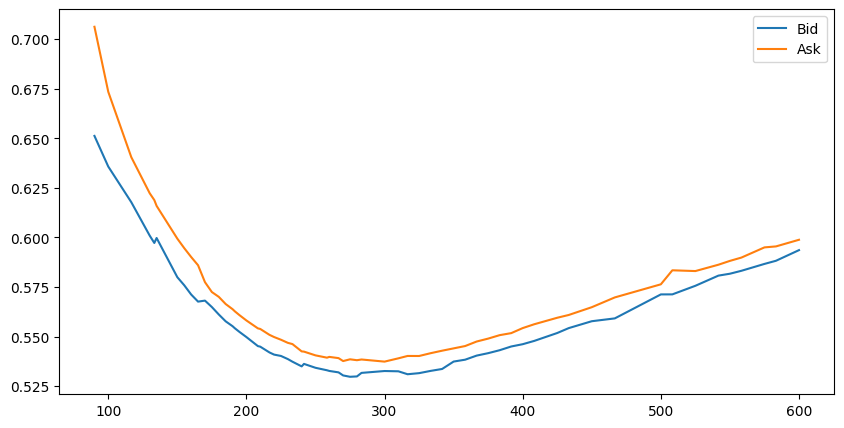

In [19]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

def D1(S, K, T, t, r, q, sigma):
    return (np.log(S / K) + (r - q + sigma**2 / 2) * (T - t)) / (sigma * np.sqrt(T - t))


def D2(S, K, T, t, r, q, sigma):
    return D1(S, K, T, t, r, q, sigma) - sigma * np.sqrt(T - t)

def BlackScholes(S, K, sgm, r, T, callput):
    try:
        if callput == 1:
            price = S * norm.cdf(D1(S, K, T, 0, r, 0, sgm), 0, 1) - K * np.exp(
                -r * T
            ) * norm.cdf(D2(S, K, T, 0, r, 0, sgm), 0, 1)
        elif callput == -1:
            price = K * np.exp(-r * T) * norm.cdf(
                -D2(S, K, T, 0, r, 0, sgm), 0, 1
            ) - S * norm.cdf(-D1(S, K, T, 0, r, 0, sgm), 0, 1)
        return price
    except:
        print("Invalid parameters.")
    pass

def BlackScholesImpVol(S, K, r, T, callput, price):
    def func(vol, S, K, r, T, callput, price):
        return BlackScholes(S, K, vol, r, T, callput) - price

    return optimize.root_scalar(
        func, bracket=[0.001, 10], args=(S, K, r, T, callput, price), method="brentq"
    ).root

data = pd.read_excel("TSLA.xlsx")
data["Expiration Date"] = pd.to_datetime(data["Expiration Date"], format="mixed")

data = data[data["Volume"] != 0]
data = data[data["Expiration Date"] == "2024-03-15"].copy().reset_index(drop=True)

T = (datetime.date(2024, 3, 15) - datetime.date(2023, 3, 8)).days / 365

r = 5.751038 / 100

data["CVol Bid"] = data.apply(
    lambda row: BlackScholesImpVol(182, row["Strike"], r, T, 1, row["Bid"]), axis=1
)
data["CVol Ask"] = data.apply(
    lambda row: BlackScholesImpVol(182, row["Strike"], r, T, 1, row["Ask"]), axis=1
)

plt.figure(figsize=(10,5))
plt.plot(data["Strike"], data["CVol Bid"], label='Bid')
plt.plot(data["Strike"], data["CVol Ask"], label='Ask')
plt.legend()

plt.show()


## Task B
Using an appropriate optimisation routine from SciPy, determine the best choice of Heston model parameters such that the squared error of the Black/Scholes implied volatilities from the Heston model prices is minimised. I.e., for a given choice of Heston model parameters, you can calculate the model prices for the same options as in Task A, and you can convert those model prices into Black/Scholes implied volatilities in the same way you converted the market prices into Black/Scholes implied volatilities in Task A. Then, a model pricing error (in terms of implied volatilities) is observed if the Black/Scholes volatility implied by the model price falls outside of the bid/ask spread - you need to choose the Heston parameters to minimise the sum of the squares of these errors.


In [64]:
from scipy.optimize import minimize

strikes = list(data['Strike'])
bid_cvol = list(data['CVol Bid'])
ask_cvol = list(data['CVol Ask'])

def to_minimize(x):
    result = 0
    for i in range(len(strikes)):
        temp = HestonOption(182, x[0], strikes[i], x[1], r, T, 1, x[2], x[3], x[4])
        vol = BlackScholesImpVol(182, strikes[i], r, T, 1, temp)
        if vol > ask_cvol[i]:
            result += ((vol - ask_cvol[i])**2)
        if vol < bid_cvol[i]:
            result += ((vol - bid_cvol[i])**2)
    return result

def constraint(x):
    return 2 * x[2] * x[3] - x[1]**2

parameters = minimize(
    to_minimize,
    [0.1]*5,
    constraints={
        'type' : 'ineq',
        'fun' : constraint,
    },
    method='SLSQP'
)
parameters

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0001351433120692107
       x: [-5.062e-02  1.439e+00  8.210e-01  1.261e+00 -2.776e-01]
     nit: 66
     jac: [-2.033e-03 -2.147e-03  1.001e-03  2.517e-04 -6.927e-04]
    nfev: 416
    njev: 66


## Task C
Plot the Black/scholes implied volatilities based on the results of Tasks A and B in a single graph (three curves).

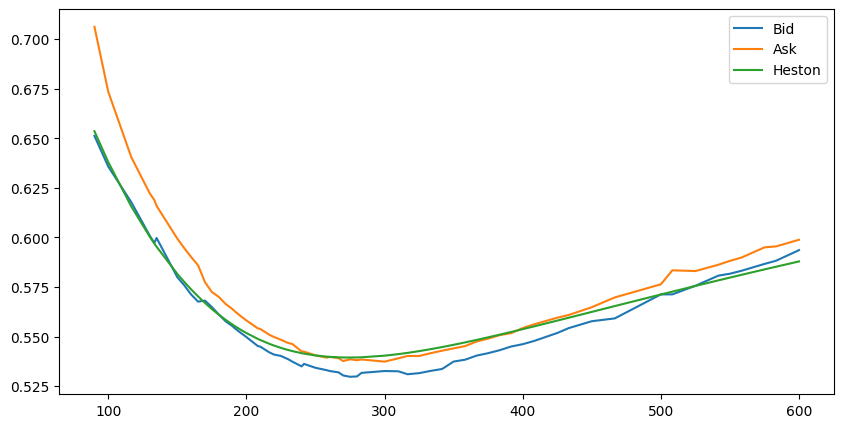

In [65]:
x = parameters.x
heston_vol = []
for i in range(len(strikes)):
    temp = HestonOption(182, x[0], strikes[i], x[1], r, T, 1, x[2], x[3], x[4])
    heston_vol.append(BlackScholesImpVol(182, strikes[i], r, T, 1, temp))

plt.figure(figsize=(10,5))
plt.plot(data["Strike"], data["CVol Bid"], label='Bid')
plt.plot(data["Strike"], data["CVol Ask"], label='Ask')
plt.plot(strikes, heston_vol, label='Heston')
plt.legend()

plt.show()